# Analysis on the unbalanced dataset

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import chisquare

In [2]:
def num_missing(x):
    return (x.isnull().sum() / x.size)

def freq_missing_value(x, value):
    freq = (x.isnull().sum() / x.size)
    return freq < value

In [3]:
#dataset loading
df = np.load('initialDataset.pkl')

The unbalanced dataset is composed by 314851 completed interviews belonging to the class 3.0 (i.e. NO Diabete) and 49718 completed interviews belonging to the class 1.0 (i.e. YES Diabete) 

Dataset distribution respect the target variable
3.0    314851
1.0     49718
Name: DIABETE3, dtype: int64


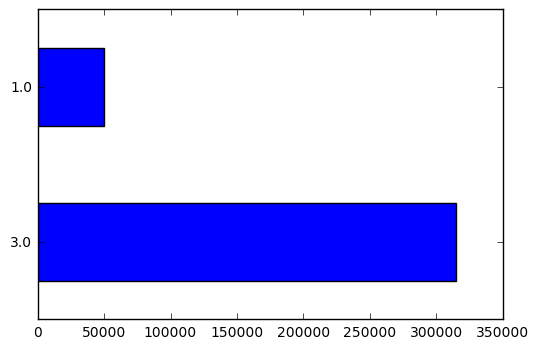

In [4]:
print("Dataset distribution respect the target variable")
print(df.DIABETE3.value_counts())
df.DIABETE3.value_counts().plot.barh()

## Analysis missing values
In the following we show the most k=10 sparse features and their number of missing values. We remove all features having a percentage of missing values greather than 80% 

In [5]:
frequency_missing_data = df.apply(num_missing, axis=0)
print("FEATURE    %_MISSING")
frequency_missing_data.sort_values(ascending=False)[0:10]

FEATURE    %_MISSING


LSATISFY    0.947807
MISTMNT     0.946427
SCNTLPAD    0.934728
EYEEXAM     0.928565
SCNTPAID    0.909803
DRADVISE    0.892465
WTCHSALT    0.892413
SCNTMNY1    0.821748
SCNTMEL1    0.809084
ARTHDIS2    0.666088
dtype: float64

In [6]:
df_filtered = df.select(lambda c: freq_missing_value(df[c],0.8), axis=1)
cols = len(df.columns) - len(df_filtered.columns)
print("Number of removed columns ", cols)

Number of removed columns  9


In [7]:
final_features = df_filtered

### Replace missing data
We replace all missing values with the value *-1*. We could analyze each feature and define for it the best *default* value (e.g. mode, median, 0, etc.). However, for the test purpose we decide to apply this trivial strategy.

In [8]:
df_add_category = df_filtered.apply(lambda s: s.cat.add_categories('-1'))

In [9]:
#modes = df.mode().iloc[0,:]
final_features = df_add_category.fillna('-1') #modes

In [10]:
df_add_category.DIABETE3 = df_add_category.DIABETE3.cat.remove_categories('-1')

## Bivariate analysis
In the following we compute the bivariate analysis between the target variable *DIABETE3* and the other features. In particular, we apply the *Spearman's Rank-Order Correlation* algorithm to compute the correlation between the target variable and all the others, and to select the most correlated features with respect to the target. The best features will be used for learning the classification model. 

The Spearman's rank-order correlation is the nonparametric version of the Pearson product-moment correlation. Spearman's correlation coefficient, measures the strength and direction of association between two ranked variables. For using this correlation algorithm we have to assume that the input variables are ordinal. Several measures of association exist in the literature for categorical variables(e.g. [Goodman and Kruskal's lambda](https://en.wikipedia.org/wiki/Goodman_and_Kruskal%27s_lambda), [Cramér's V](https://en.wikipedia.org/wiki/Cramér%27s_V), [Chi-Square Test of Independence](https://onlinecourses.science.psu.edu/stat500/node/56), etc.). However, in my knowledge, do not exist any python implementation publically available. How you can see I have implemented the method *chi_square_of_df_cols* to compute the chi-square test of independency, but it doesn't perform on the input dataset.  

Considering what we said before, for the purpose of the test we select only feature having a positive Spearman correlation score. 

Note that the extracted features could be correlated among them. In general, it could be better to choose a set of features which are as much correlate as possible with the target vaiable and orthogonal among them. This can be obtained for example applying algorithms such as PCA o SVD which return both a new feature space and the most important and orthogonal features.

Goal of this Bivariate Analysys task is to extract a feature set that will be used by the classification algorithms, in the way to increase their perfomances (in terms of computational time and results quality).


In [11]:
import pandas as pd
import scipy.stats as scs


def categories(series):
    return range(int(series.min()), int(series.max()) + 1)


def chi_square_of_df_cols(df, col1, col2):
    df_col1, df_col2 = df[col1], df[col2]

    result = [[sum((df_col1 == cat1) & (df_col2 == cat2))
               for cat2 in categories(df_col2)]
              for cat1 in categories(df_col1)]

    return scs.chi2_contingency(result)

In [12]:
final_features_numeric = final_features.apply(lambda c: c.astype('int'))

In [13]:
#compute correlation
#correlation_cleaned = final_features.corr(method='spearman')
correlation_cleaned = final_features_numeric.corr(method='spearman')

In [14]:
cleaned_sorted_features = correlation_cleaned.DIABETE3.sort_values(ascending=False)

In [15]:
cleaned_selected_features = cleaned_sorted_features[cleaned_sorted_features >= 0]

In [16]:
print("FEATURE    %CORRELATION")
cleaned_selected_features.head()

FEATURE    %CORRELATION


DIABETE3    1.000000
BPHIGH4     0.271867
DIFFWALK    0.225912
USEEQUIP    0.190007
_MICHD      0.182062
Name: DIABETE3, dtype: float64

## Visualize the distribution of most correlated features with the target

In the following we show the distribution of the most k=4 correlate features with the target variable:
* BPHIGH4: Have you EVER been told by a doctor, nurse or other health professional that you have high blood pressure? (1: Yes, 3: No);
* DIFFWALK: Do you have serious difficulty walking or climbing stairs? (1:Yes, 2:No)
* USEEQUIP: Do you now have any health problem that requires you to use special equipment, such as a cane, a wheelchair, a special bed, or a special telephone? (1: Yes, 2: No)
* _MICHD: Respondents that have ever reported having coronary heart disease (CHD) or myocardial infarction (MI) (1:Yes, 2:No)

There is not a high correlation (i.e. >80%) between the target variable and the features set.

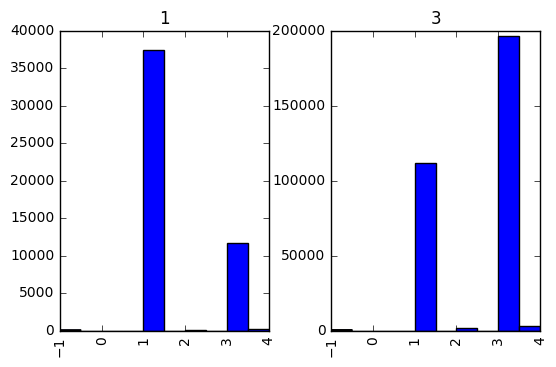

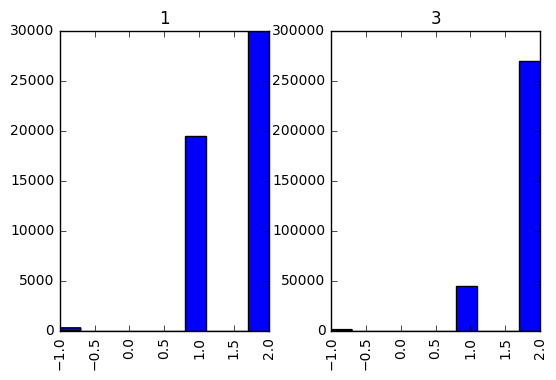

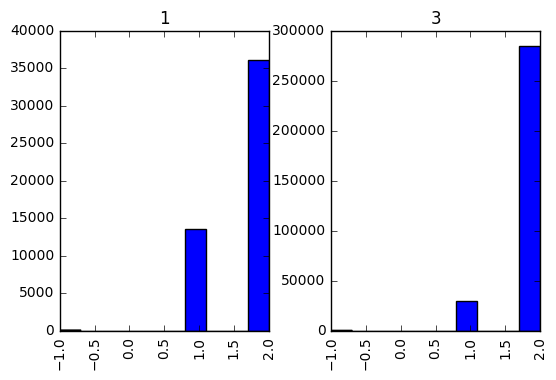

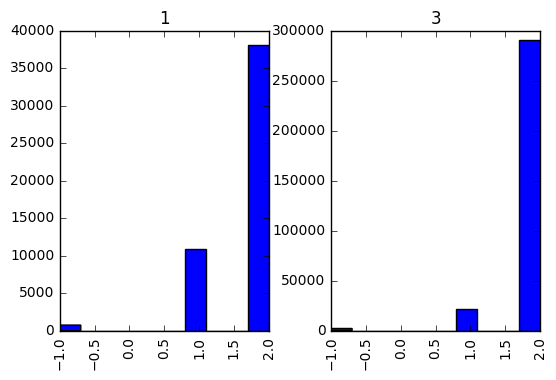

In [20]:
for i in cleaned_selected_features[1:5].index:
    final_features_numeric.hist(column=i, by="DIABETE3")  

## Data Storage

We store the pre-processed dataset for further analysis

In [18]:
to_store_df = final_features[cleaned_selected_features.index]

In [19]:
to_store_df.to_pickle("unbalanced_final_dataset.pkl")